# Data Prepocessing

The following steps are taken to preprocess the data.

- **1. Shapefiles**
    - Load shapefiles (stream gages, precipitation stations, boundaries).
    - Clean, simplify, and reproject shapefiles.
    - Clip and mask data based on region of interest.
    - Create Thiessen Polygons for precipitation stations for taking into account the spatial distibution of rain.
    - Extract relevant features (e.g., drainage area, station location).

- **2. Raster Data**
    - Load raster data (elevation, land cover).
    - Resample and align raster data layers.
    - Clip and mask data based on region of interest.
    - Extract key features (e.g., elevation, impervious surface).
    - Delineate watershed boundaries and extract watershed geomorphological characteristics
    - Normalize raster values.

- **3. Tabular Data**
    - Load time-series data (streamflow, precipitation).
    - Handle missing values and fill gaps.
    - Standardize time formats and indices.
    - Identify and remove outliers.
    - Resample and aggregate data to a uniform time step.
    - Create new features (e.g., moving averages).

- **4. Data Integration**
    - Spatially join shapefiles with raster and tabular data.
    - Merge time-series data based on time and location.
    - Aggregate raster features for each station or gage.

- **5. Selection of Storm Events**

- **6. Clark's parameter optmization**
    - Optmize Clark's parameters for the selected events
    - Spatially join the optmized parameters with shapefile data.

- **5. Machine Learning Preparation**
    - Scale and normalize features.
    - Split dataset into training and testing sets.
    - Encode categorical features.
    - Select most relevant features for training.


In [1]:
# Import modules
from pathlib import Path
import time
import sys
import geopandas as gpd
from shapely.geometry import Point
from plotnine import *
import warnings
from dotenv import load_dotenv
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import json
import pickle

In [2]:
# File paths
project_base_path = Path.cwd().parent.parent

In [3]:
# Add 'src' to system path
sys.path.append(str(project_base_path / 'src'))

# Import modules
from preprocessing.thiessenPolygons import derive_thiessen_polygons
from utils.save_workspace import save_workspace

# Ignore warnings
warnings.filterwarnings('ignore')

In [4]:
# Load tokens
load_dotenv(project_base_path / '.env')

NOAA_API_TOKEN = os.getenv('NOAA_API_TOKEN')

## 1. Shapefiles

### 1.1 Load shapefiles

In [5]:
# File paths
shapefiles_base_path = project_base_path / 'data'/ 'raw' / 'geo'/ 'shp'

dam_location_path = shapefiles_base_path / 'dams_location' / 'Dams.shp'

precip_stations_v1_path = shapefiles_base_path / 'precipitation_stations' / 'precip_15.kmz'
precip_stations_v2_path = project_base_path /  'data'/ 'raw' / 'geo'/ 'json' / 'ppt_stations_inventory.json'

streamgage_stations_path = shapefiles_base_path / 'streamgage_stations' / 'realstx.shp'

us_county_path = shapefiles_base_path / 'us_county' / 'tl_2024_us_county.shp'
us_state_path =  shapefiles_base_path / 'us_state' / 'tl_2024_us_state.shp'

world_utm_zones_path = shapefiles_base_path.parent / 'json' / 'World_UTM_Grid.geojson'

upper_hudson_basin_path = shapefiles_base_path / 'upper_hudson_basin' / 'upper_hudson_basin.shp'
upper_hudson_basin_1km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_1km_buffer' / 'upper_hudson_basin_1km_buffer.shp'
upper_hudson_basin_5km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_5km_buffer' / 'upper_hudson_basin_5km_buffer.shp'
upper_hudson_basin_10km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_10km_buffer' / 'upper_hudson_basin_10km_buffer.shp'
upper_hudson_basin_30km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_30km_buffer' / 'upper_hudson_basin_30km_buffer.shp'

In [6]:
# Read shapefiles
try:
    start_time = time.time()

    precip_stations_v1 = gpd.read_file(precip_stations_v1_path)
    precip_stations_v2 = pd.read_json(precip_stations_v2_path)

    streamgage_stations = gpd.read_file(streamgage_stations_path)

    dam_location = gpd.read_file(dam_location_path)

    us_county = gpd.read_file(us_county_path)
    us_state = gpd.read_file(us_state_path)

    world_utm_zones = gpd.read_file(world_utm_zones_path)

    upper_hudson_basin = gpd.read_file(upper_hudson_basin_path)
    upper_hudson_basin_1km_buffer = gpd.read_file(upper_hudson_basin_1km_buffer_path)
    upper_hudson_basin_5km_buffer = gpd.read_file(upper_hudson_basin_5km_buffer_path)
    upper_hudson_basin_10km_buffer = gpd.read_file(upper_hudson_basin_10km_buffer_path)
    upper_hudson_basin_30km_buffer = gpd.read_file(upper_hudson_basin_30km_buffer_path)

    end_time = time.time()

    print('Shapefiles read successfully. Time elapsed:', round(end_time - start_time, 2), 'seconds')
except Exception as err:
    print('Error reading shapefiles:', err)

Shapefiles read successfully. Time elapsed: 10.02 seconds


### 1.2. Clean and Prepare Datasets
#### 1.2.1. Precipitation Stations

There are two datasets for precipitation locations, V1 with data up to 2013 and V2 with up-to-date data. Those data set covers the entire country and a lot of V2 precipitation stations overlaps V1. They are in `.kmz` and `.json` format V1 and V2 repectevely,  the ID station for V1 is encoded in HTML code, have irrelevant attributes. We will keep both datasets and use them indenpendetly. The following steps will be taken to clean and prepare the dataset:

- **1. Clip the data to have precipitation stations only in area of interest.**
- **2. Decode the HTML code to extract the station ID and elevation.**
- **3. Drop irrelevant attributes.**
- **4. Add begin and end historical data info.**
- **5. Reproject.**
- **6. Evaluate the number of stations within the buffer zones**
- **6. Generate Thiessen Polygons to account for spatial distribution of rain.**
- **7. Export station ID and relevant attributes in JSON format.** That document will be used later to download precipitation data.


**1.2.1.1. Clip the Data**

For the mask, we will use the study region + 30km buffer to make ensure that none of possible precipitation station is left outside. We will define later which station to use. 


In [7]:
# Convert to geopandas object
nad83_epsg = 'EPSG:4269'
precip_stations_v2['geometry'] = precip_stations_v2.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)
precip_stations_v2 = gpd.GeoDataFrame(data=precip_stations_v2, crs=nad83_epsg)

# Clip the data
precip_stations_v1_clipped = gpd.clip(precip_stations_v1.to_crs(upper_hudson_basin_30km_buffer.crs), upper_hudson_basin_30km_buffer)
precip_stations_v2_clipped = gpd.clip(precip_stations_v2.to_crs(upper_hudson_basin_30km_buffer.crs), upper_hudson_basin_30km_buffer)

In [8]:
# Load map styles
# Load style configuration for maps
map_styles_path = project_base_path / 'config' / 'map_styles.json'
with open(map_styles_path, 'r') as f:
    map_style = json.load(f).get('map_styles',[])

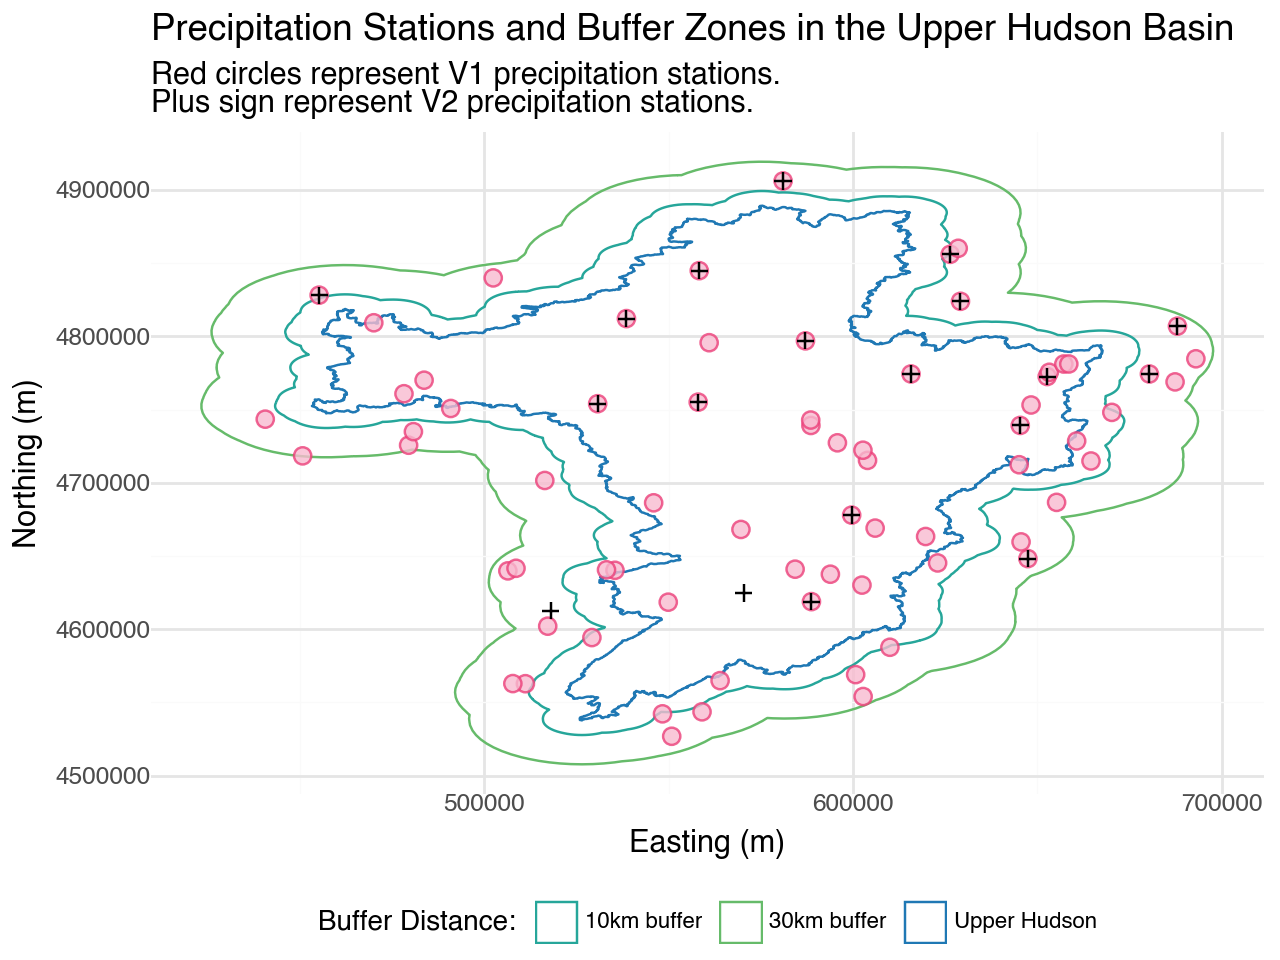

In [9]:
geom_merged = pd.concat(
    [
        upper_hudson_basin.to_crs(precip_stations_v1_clipped.crs)[['geometry']].assign(LAYER='Upper Hudson'),
        upper_hudson_basin_10km_buffer[['geometry']].assign(LAYER='10km buffer'),
        upper_hudson_basin_30km_buffer[['geometry']].assign(LAYER='30km buffer')
    ]
)

precip_station_map = (
    ggplot(geom_merged)
    + geom_map(
        mapping=aes(geometry='geometry', color = 'LAYER'),
        fill = None
    )
    + geom_map(
        data=precip_stations_v1_clipped,
        mapping=aes(geometry='geometry'),
        color=map_style.get('precipitation_station_v1').get('color'),
        fill = map_style.get('precipitation_station_v1').get('fill'),
        shape = map_style.get('precipitation_station_v1').get('shape'),
        size = 3,
        alpha = 0.8
    )
    + geom_map(
        data = precip_stations_v2_clipped[['geometry']],
        mapping=aes(gemetry='geometry'),
        color=map_style.get('precipitation_station_v2').get('color'),
        shape = map_style.get('precipitation_station_v2').get('shape'),
        size = 3,
        alpha = 1
    )
    + labs(title='Precipitation Stations and Buffer Zones in the Upper Hudson Basin',
           subtitle= 'Red circles represent V1 precipitation stations.\nPlus sign represent V2 precipitation stations.',
           x = "Easting (m)", y = "Northing (m)")

    # Manually define colors
    + scale_color_manual(
        name='Buffer Distance:',
        values={
            'Upper Hudson': map_style.get('watershed_boundary').get('color'),
            '10km buffer': map_style.get('watershed_boundary_buffer_10km').get('color'),
            '30km buffer': map_style.get('watershed_boundary_buffer_30km').get('color')
            }
    )
    + coord_cartesian()
    + theme_minimal()
    + theme(
        legend_title=element_text(size=10),
        legend_text=element_text(size=8),
        legend_position='bottom'
    )
)
precip_station_map.show()


In [10]:
# Number of precipitation stations
print('For the study region:')
print(f'There are {precip_stations_v1_clipped.shape[0]} V1 precipitation stations.')
print(f'There are {precip_stations_v2_clipped.shape[0]} V2 precipitation stations.')


For the study region:
There are 70 V1 precipitation stations.
There are 19 V2 precipitation stations.


**1.2.1.2. Decode HTML**

The station ID and elevation attributes, which we want to keep, are encoded in HTML tags. We will extract those attributes and add it to a new column called `precip_station_id`  and `precip_station_elev` respectively. Precipitation elevation is in meters. Below is an example of precipitation station description encoded as html:`

In [11]:
print(precip_stations_v1_clipped['description'].iloc[0])


    
    <table>
    <tr><td>ID: COOP:280907</td></tr>
    <tr><td>COUNTRY: United States</td></tr>
    <tr><td>LATITUDE: 40.89174</td></tr>
    <tr><td>LONGITUDE: -74.39635</td></tr>
    <tr><td>ELEVATION: 85.3 m.</td></tr>
    <tr><td></td></tr>
    </table>
    <table>
    <tr><td><form action="https://www.ncdc.noaa.gov/cdo-web/mapReview" method="post">
        <input type="hidden" name="_dataSet" value="PRECIP_15"/>
        <input type="hidden" name="_stationId" value="COOP:280907"/>
        <input type="submit" value="Access Station Data"/>
    </form></td></tr>
    </table> 
  


In [12]:
# Define function to extract precipitation station id and elevation attributes
def decode_precipt_station_html(html):
    soup = BeautifulSoup(html, 'html.parser')
    id = soup.find('td').text.split(': ')[1].strip()
    elevation = soup.find_all('td')[4].text.split(': ')[1]
    elevation_float = float(elevation.split()[0])

    return pd.Series([id, elevation_float])

# Extract attributes
try:
    precip_stations_v1_clipped[['precip_station_id', 'precip_station_elev']] = precip_stations_v1_clipped['description'].apply(decode_precipt_station_html)
    print('Attribute successfully extracted.')
except Exception as err:
    print(f'Failed to extract attibutes: {err}')

Attribute successfully extracted.


**1.2.1.3. Drop irrelevant attributes**

Below is shows all of the attributes in the V1 precipitation station layer. The relevant attributes are: `Name`, `geometry`, `precip_station_id` and `precip_station_elev`. `begin` and `end` are relavant but they are empty and we will not keep it.

In [13]:
precip_stations_v1_clipped.head()

,id,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry,precip_station_id,precip_station_elev
30,31,"BOONTON 1 SE, NJ US",\n \n <table>\n <tr><td>ID: COOP:2809...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (550850.97 4526914.624 0),COOP:280907,85.3
1,2,"CHARLOTTEBURG RESERVOIR, NJ US",\n \n <table>\n <tr><td>ID: COOP:2815...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (548355.898 4542242.25 0),COOP:281582,237.1
2,3,"WANAQUE RAYMOND DAM, NJ US",\n \n <table>\n <tr><td>ID: COOP:2891...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (559071.261 4543608.511 0),COOP:289187,71.9
225,226,"PLEASANTVILLE, NY US",\n \n <table>\n <tr><td>ID: COOP:3066...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (602750.905 4554064.92 0),COOP:306674,97.5
438,439,"DINGMANS FERRY, PA US",\n \n <table>\n <tr><td>ID: COOP:3621...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (511176.454 4562818.525 0),COOP:362160,131.1


In [14]:
# Remove irrelevant attributes
keep_attributes = ['Name', 'geometry', 'precip_station_id', 'precip_station_elev']
precip_stations_clipped = precip_stations_v1_clipped[keep_attributes]
precip_stations_clipped.head()

,Name,geometry,precip_station_id,precip_station_elev
30,"BOONTON 1 SE, NJ US",POINT Z (550850.97 4526914.624 0),COOP:280907,85.3
1,"CHARLOTTEBURG RESERVOIR, NJ US",POINT Z (548355.898 4542242.25 0),COOP:281582,237.1
2,"WANAQUE RAYMOND DAM, NJ US",POINT Z (559071.261 4543608.511 0),COOP:289187,71.9
225,"PLEASANTVILLE, NY US",POINT Z (602750.905 4554064.92 0),COOP:306674,97.5
438,"DINGMANS FERRY, PA US",POINT Z (511176.454 4562818.525 0),COOP:362160,131.1


**V2 Precipitation Stations**

For **V2 precipitation stations** the follwoing attributes are relevant:  `StnID`,`Lat`,`Lon`,`Elev`,`Name`, `Sample_Interval (min)`,`UTC_Offset`,`POR_Date_Range`,`PCT_Last_Half_Good`, `geometry`. For a detailed explanation about the attributes [refere to the docs](../../docs/other/readme.15min.txt).

In [15]:
keep_attributes = ['StnID','Lat','Lon','Elev','Name', 'Sample_Interval (min)','UTC_Offset','POR_Date_Range','PCT_Last_Half_Good', 'geometry']
precip_stations_v2_clipped = precip_stations_v2_clipped[keep_attributes]
precip_stations_v2_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 19 entries, 1161 to 1157
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   StnID                  19 non-null     object  
 1   Lat                    19 non-null     float64 
 2   Lon                    19 non-null     float64 
 3   Elev                   19 non-null     float64 
 4   Name                   19 non-null     object  
 5   Sample_Interval (min)  19 non-null     int64   
 6   UTC_Offset             19 non-null     int64   
 7   POR_Date_Range         19 non-null     object  
 8   PCT_Last_Half_Good     19 non-null     object  
 9   geometry               19 non-null     geometry
dtypes: float64(3), geometry(1), int64(2), object(4)
memory usage: 1.6+ KB


**1.2.1.4. Add relevant attributes**

The downloaded precipitation stations location layer does not have `begin` and `end`info on its attributes. This info is important to dowloading ([see this notebook](../data%20download/data_download.ipynb)) the historical precipitation data. We tried to retrieve this info from NOOA API. [Documentation available here](https://www.ncdc.noaa.gov/cdo-web/webservices/v2) however, it returns the same date operational periods for each station. Therefore we will not keep it. Below is the code for downloading V1 station metadata.

**Begin** and **End** dates:

In [14]:
def get_precip_station_operational_dates(station_id, token=NOAA_API_TOKEN):
    """
    Retrieves the operational begin and end dates for a given precipitation station.

    Parameters:
        station_id (str): The ID of the precipitation station.
        token (str): NOAA API token.

    Returns:
        dict: Contains 'begin', 'end', and 'n_requests'.
    """
    base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/'
    headers = {"Token": token}
    endpoint = 'datasets'
    parameters = {'stationid': station_id}
    max_retries = 4
    count = 0

    for attempt in range(1, max_retries + 1):
        count += 1
        try:
            response = requests.get(url=base_url + endpoint, headers=headers, params=parameters)
            response.raise_for_status()
            data = response.json()

            # Check if 'results' exists and is not empty
            if 'results' not in data or not data['results']:
                raise ValueError(f"No results found for station ID {station_id}")

            begin = data['results'][0].get('mindate')
            end = data['results'][0].get('maxdate')

            return {'begin': begin, 'end': end, 'n_requests': count}

        except (requests.exceptions.RequestException, ValueError) as err:
            print(f"Attempt {attempt} failed for station ID {station_id}: {err}")
            if attempt == max_retries:
                # Return only 'n_requests' to indicate failure
                return {'n_requests': count}
            time.sleep(1)  # Wait before retrying

    # In case the loop exits without returning (shouldn't happen)
    return {'n_requests': count}


In [48]:
overall_start_time = time.time()
# Add begin and end date to geodataframe 
failed_stations_id = []
request_count = 0
start_time = time.time()

for i, row in precip_stations_clipped.iterrows():
    print(f'Getting operational dates for station {row['precip_station_id']}', end= '\r')
    
    # Retrieving only for NaT values
    if row['begin'] is not pd.NaT or row['end'] is not pd.NaT:
        continue

    current_time = time.time()
    elapsed_time = current_time - start_time

    # Reset the counter and timer every second
    if elapsed_time > 1:
        request_count = 0
        start_time = current_time

    if request_count >= 4:
        time.sleep(1)
        request_count = 0
        start_time = time.time()

    try:
        dates = get_precip_station_operational_dates(station_id=row['precip_station_id'])
        request_count += dates.get('n_requests')

    except Exception as err:
        failed_stations_id.append(row['precip_station_id'])
        print(f"Request for data failed for station ID {row['precip_station_id']}: {err}")
        request_count += dates.get('n_requests')
        continue

    if dates:
        try:
            precip_stations_clipped.at[i, 'begin'] = dates.get('begin')
            precip_stations_clipped.at[i, 'end'] = dates.get('end')
        except Exception as err:
            failed_stations_id.append(row['precip_station_id'])
            print(f"Failed to get dates for station ID {row['precip_station_id']}: {err}")
            continue

overall_start_time_str = f"Elapsed time: {round(time.time()-overall_start_time, 2)} seconds."
if failed_stations_id:
    print(f"Ended getting data. Failed for the following stations: {', '.join(failed_stations_id)}. " + overall_start_time_str)
else:
    print(f"Successfully retrieved all begin and end dates. " + overall_start_time_str)

Attempt 1 failed for station ID COOP:301987: 503 Server Error: Service Unavailable for url: https://www.ncei.noaa.gov/cdo-web/api/v2/datasets?stationid=COOP%3A301987
Successfully retrieved all begin and end dates. Elapsed time: 74.66 seconds.


**1.2.1.5. Reproject**

When working with geospatial data in the Upper Hudson River Basin, selecting an appropriate map projection is essential to ensure the accuracy of spatial attribute calculations, such as area and perimeter. For this study, the **NAD83 datum** has been chosen as it is widely used for regional geospatial analysis within the United States. Specifically, we will utilize the **NAD83 / UTM Zone 18N (EPSG:26918)** projection, which is well-suited for the geographic extent of the Hudson River Basin.

The UTM Zone 18N projection minimizes distortions in distance and area measurements by dividing the Earth into zones optimized for small regions. This makes it ideal for hydrological studies and sub-basin analyses, where precision is critical. The projection's use of meters as the measurement unit simplifies calculations of spatial attributes, ensuring consistency and ease of interpretation.

For larger-scale or cross-basin analyses, equal-area projections such as **Albers Equal Area (EPSG:5070)** or **Lambert Conformal Conic (EPSG:102009)** can be considered. However, for this focused study on sub-basins within the Upper Hudson River region, the selected UTM projection provides the most practical and accurate framework.


In [16]:
# Filter UTM bounds to be within the bounds of the upper hudson basin
upper_hudson_basin_bounds = list(upper_hudson_basin.total_bounds)

utm_bounds = world_utm_zones.bounds

utm_intersecting_bounds = (
    (utm_bounds['minx'] < upper_hudson_basin_bounds[2]) &  # UTM left < Basin right
    (utm_bounds['maxx'] > upper_hudson_basin_bounds[0]) &  # UTM right > Basin left
    (utm_bounds['miny'] < upper_hudson_basin_bounds[3]) &  # UTM bottom < Basin top
    (utm_bounds['maxy'] > upper_hudson_basin_bounds[1])    # UTM top > Basin bottom
)
world_utm_zones_filtered = world_utm_zones[utm_intersecting_bounds]

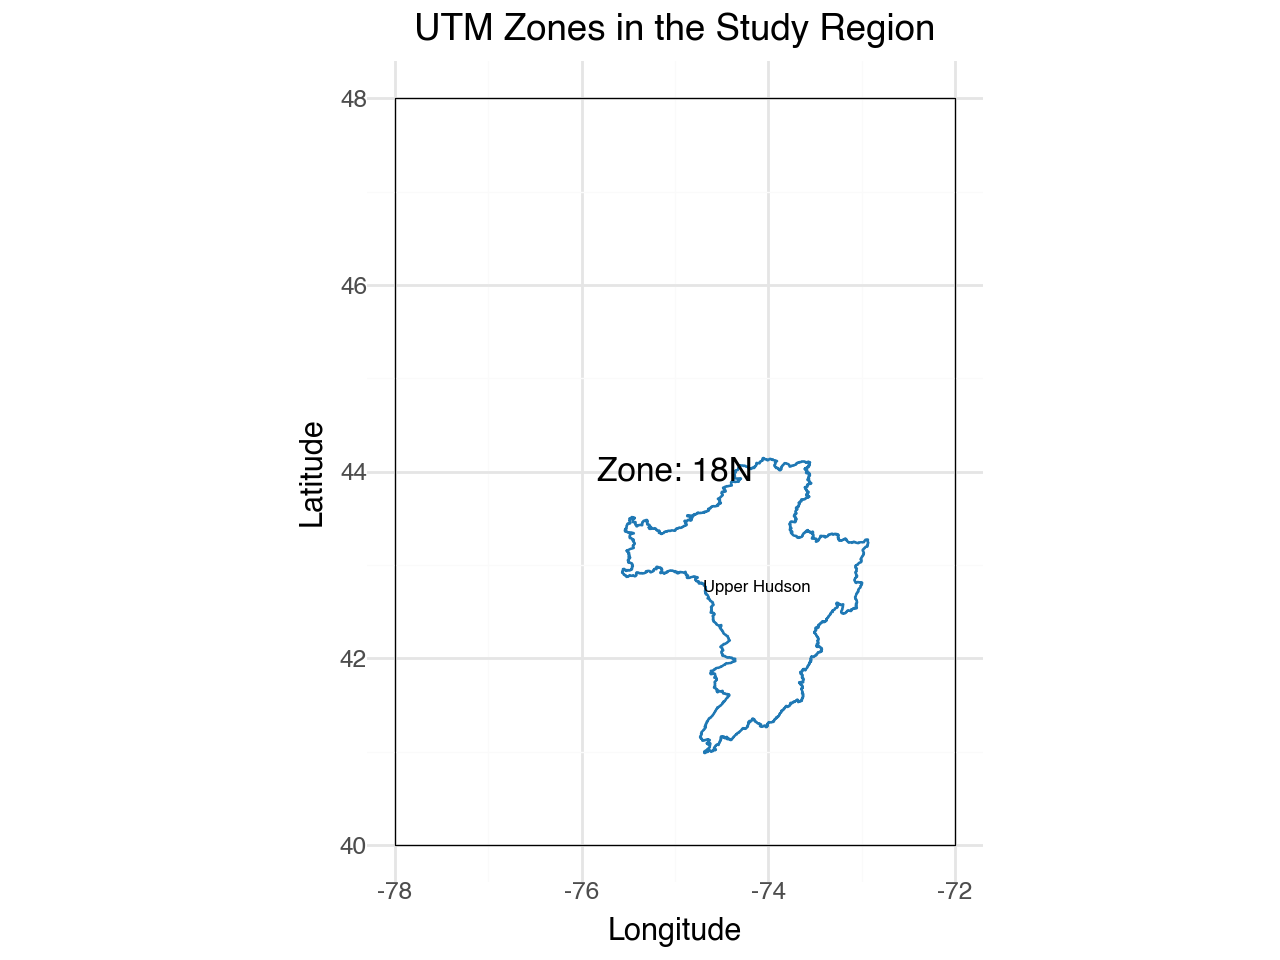

In [17]:
# Define centroid for text legend
world_utm_zones_filtered['lon'] = world_utm_zones_filtered.centroid.x
world_utm_zones_filtered['lat'] = world_utm_zones_filtered.centroid.y

world_utm_zones_filtered['ZONE_str'] = 'Zone: ' + world_utm_zones_filtered['ZONE'].astype(str)+'N'

# Map
utm_zones_map = (
    ggplot(upper_hudson_basin)
        + geom_map(
            mapping=aes(geometry="geometry"),
            inherit_aes=True, 
            color = map_style.get('watershed_boundary').get('color'),
            fill=None
        )
         + geom_text(
            mapping=aes(x="lon", y="lat", label="name"),
            size=6,
            color="black"
        )
        + geom_map(
            mapping=aes(geometry="geometry"),
            data=world_utm_zones_filtered,
            inherit_aes=False,
            color="black",
            size=0.25,
            fill = None
        )
        + geom_text(
            mapping=aes(x="lon", y="lat", label="ZONE_str"),
            size=12,
            color="black",
            data = world_utm_zones_filtered,
            inherit_aes=False
        )
        + coord_fixed()
        + theme_minimal()
        + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
        + labs(title="UTM Zones in the Study Region", x="Longitude", y="Latitude")
    
)
utm_zones_map
                 

In [18]:
target_crs = "EPSG:26918"  # UTM Zone 18N

# Reproject precipitation station and basin layers
precip_stations_v1_clipped = precip_stations_v1_clipped.to_crs(target_crs)
precip_stations_v2_clipped = precip_stations_v2_clipped.to_crs(target_crs)

upper_hudson_basin = upper_hudson_basin.to_crs(target_crs)
upper_hudson_basin_10km_buffer = upper_hudson_basin_10km_buffer.to_crs(target_crs)
upper_hudson_basin_30km_buffer = upper_hudson_basin_30km_buffer.to_crs(target_crs)


**1.2.1.6. Precipitations Stations Within the Buffer Zones**

Depending on the number of sations that fall outside the uppder hudson basin but whithin the limits of 10 or 30km buffer, we will keep stations outside the basin with the goal of increasing our available data.

In [19]:
precip_stations_v1_clipped['within_basin'] = precip_stations_v1_clipped.within(upper_hudson_basin.unary_union)
precip_stations_v1_clipped['within_10kmbuffer'] = precip_stations_v1_clipped.within(upper_hudson_basin_10km_buffer.unary_union)
precip_stations_v1_clipped['within_30kmbuffer'] = precip_stations_v1_clipped.within(upper_hudson_basin_30km_buffer.unary_union)

print(f'For V1 There are {sum(precip_stations_v1_clipped['within_basin'])} stations within boundaries of basin.')
print(f'+ {sum(precip_stations_v1_clipped['within_10kmbuffer'])- sum(precip_stations_v1_clipped['within_basin'])} stations in 10km buffer,')
print(f'+ {sum(precip_stations_v1_clipped['within_30kmbuffer'])- sum(precip_stations_v1_clipped['within_10kmbuffer'])} stations in 30km buffer.\n\n')

precip_stations_v2_clipped['within_basin'] = precip_stations_v2_clipped.within(upper_hudson_basin.unary_union)
precip_stations_v2_clipped['within_10kmbuffer'] = precip_stations_v2_clipped.within(upper_hudson_basin_10km_buffer.unary_union)
precip_stations_v2_clipped['within_30kmbuffer'] = precip_stations_v2_clipped.within(upper_hudson_basin_30km_buffer.unary_union)

print(f'For V2 There are {sum(precip_stations_v2_clipped['within_basin'])} stations within boundaries of basin,')
print(f'+ {sum(precip_stations_v2_clipped['within_10kmbuffer'])- sum(precip_stations_v2_clipped['within_basin'])} stations in 10km buffer.')
print(f'+ {sum(precip_stations_v2_clipped['within_30kmbuffer'])- sum(precip_stations_v2_clipped['within_10kmbuffer'])} stations in 30km buffer.')

For V1 There are 31 stations within boundaries of basin.
+ 10 stations in 10km buffer,
+ 29 stations in 30km buffer.


For V2 There are 11 stations within boundaries of basin,
+ 0 stations in 10km buffer.
+ 8 stations in 30km buffer.


We decide to define the 30km buffer as the area of influence in the study region for precipitation events. 

**1.2.1.6 Thiessen Polygons**

Thiessen polygons, also known as Voronoi polygons or Dirichlet tessellations, are a way to partition a plane into regions based on the distance to points in a specific subset of the plane. For each point, there is a corresponding polygon consisting of all points closer to that point than to any other.

On the context of this study we have several scattered points representing precipitation stations. A Thiessen polygon for a given station encompasses the area that is closer to that station than to any other point in the set. Visually, these polygons are constructed by drawing perpendicular bisectors between each pair of points. The intersections of these bisectors create the boundaries of the polygons.

Thiessen polygons are important tool for defining areas of influence for they provide a clear and unambiguous way to define the area of influence of each point. This is crucial in determining which weather station is most representative of a given location.

However, while simple to understand and implement, Thiessen polygons have limitations. They assume abrupt changes at polygon boundaries and don't account for factors like terrain or other spatial influences. Nontheless, they remain a valuable tool for our model. Since we are working with precipitation stations independetly, we generate thiessen polygon for both precipitations dataset.

In [20]:
try:
    thiessen_polygons_v1_ds = derive_thiessen_polygons(
        gdf_points=precip_stations_v1_clipped,
        clipping_gdf= upper_hudson_basin,
        preserve_attribute='precip_station_id')
    print(f'Thiessen Polygon successfully derived for V1 dataset.')
except Exception as err:
    print(f'Failed to derive Thiessen Polygon for V1 dataset: {err}')

try:
    thiessen_polygons_v2_ds = derive_thiessen_polygons(
        gdf_points=precip_stations_v2_clipped,
        clipping_gdf= upper_hudson_basin,
        preserve_attribute='StnID')
    print(f'Thiessen Polygon successfully derived for V2 dataset.\n')
    
    print(f'{thiessen_polygons_v1_ds.shape[0]} V1 precipitation stations out of {precip_stations_v1_clipped.shape[0]} cover the basin.')
    print(f'{thiessen_polygons_v2_ds.shape[0]} V2 precipitation stations out of {precip_stations_v2_clipped.shape[0]} cover the basin.')

except Exception as err:
    print(f'Failed to derive Thiessen Polygon for V2 dataset: {err}')

Thiessen Polygon successfully derived for V1 dataset.
Thiessen Polygon successfully derived for V2 dataset.

53 V1 precipitation stations out of 70 cover the basin.
18 V2 precipitation stations out of 19 cover the basin.


**Drop unused precipitation stations**

Not all of precipitation stations influence the study region based on Thiessen Polygon. Those stations are dropped from the study. 

In [27]:
precip_stations_v1_filtered = precip_stations_v1_clipped[precip_stations_v1_clipped['precip_station_id'].isin(thiessen_polygons_v1_ds['precip_station_id'])]
precip_stations_v2_filtered = precip_stations_v2_clipped[precip_stations_v2_clipped['StnID'].isin(thiessen_polygons_v2_ds['StnID'])]

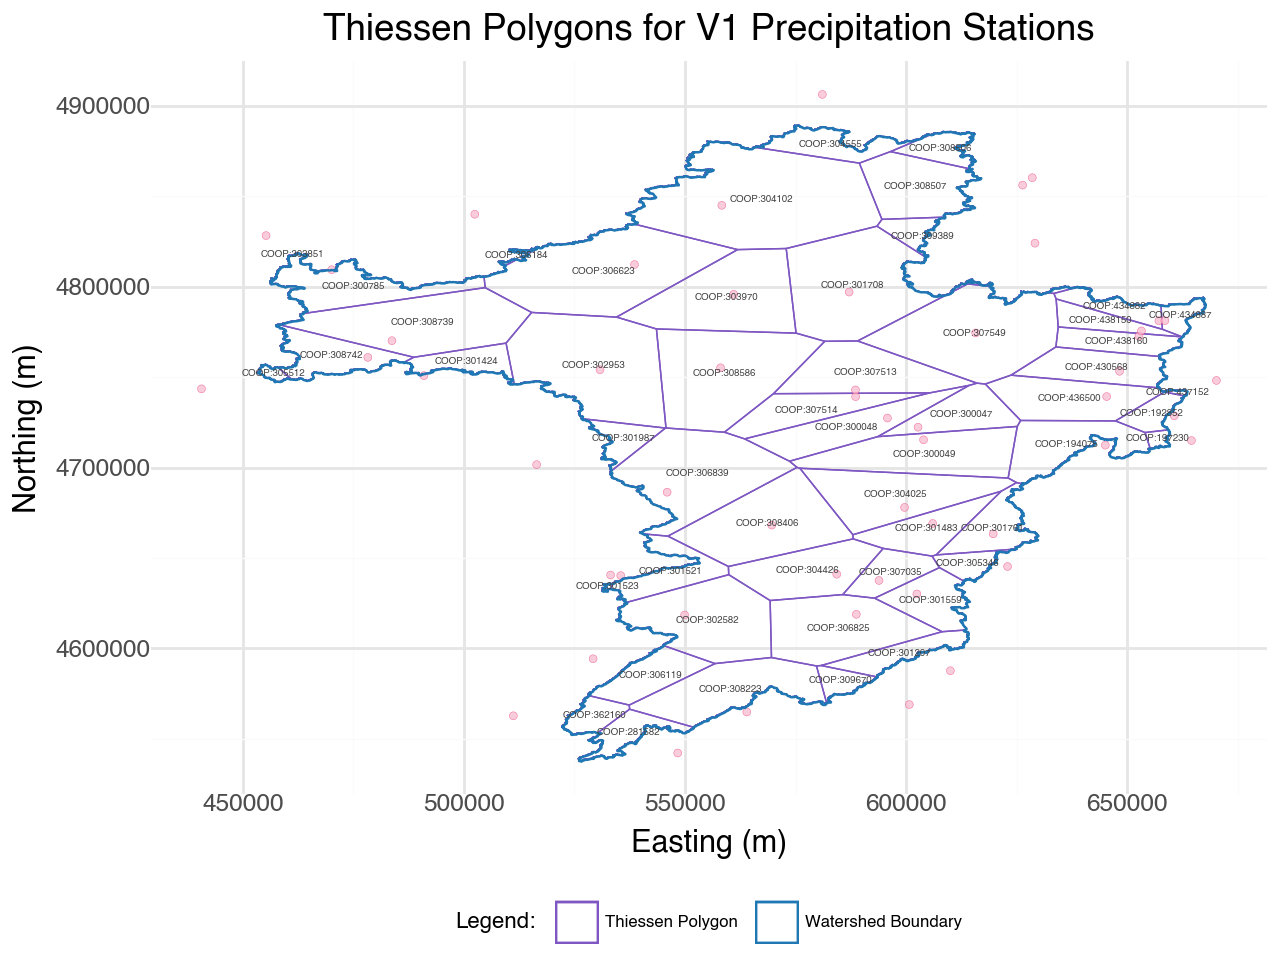

In [28]:
# Compute centroids for placing labels
thiessen_polygons_v1_ds['x'] = thiessen_polygons_v1_ds.centroid.x
thiessen_polygons_v1_ds['y'] = thiessen_polygons_v1_ds.centroid.y

# Add a new column to indicate the type of feature for color mapping
thiessen_polygons_v1_ds['feature_type'] = 'Thiessen Polygon'
upper_hudson_basin['feature_type'] = 'Watershed Boundary'

# Build the plot
thiessen_polygons_v1ds_map = (
    ggplot()
    
    # Thiessen Polygons layer
    + geom_map(
        data=thiessen_polygons_v1_ds,
        mapping=aes(geometry='geometry', color='feature_type'),
        fill=None,
        size=0.3,
        show_legend=True
    )
    
    # Precipitation Stations layer
    + geom_map(
        data=precip_stations_v1_filtered,
        mapping=aes(geometry='geometry'),
        shape = map_style.get('precipitation_station_v1').get('shape'),
        color = map_style.get('precipitation_station_v1').get('color'),
        fill = map_style.get('precipitation_station_v1').get('fill'),
        alpha=0.75,
        size =1.5, 
        stroke = 0.1
    )
    
    # Upper Hudson Basin layer
    + geom_map(
        data=upper_hudson_basin,
        mapping=aes(geometry='geometry', color='feature_type'),
        fill=None,
        show_legend=True
    )
    
    # Add labels for precipitation station IDs (using the centroids)
    + geom_text(
        data=thiessen_polygons_v1_ds,
        mapping=aes(x='x', y='y', label='precip_station_id'),
        size=3.5,
        color=map_style.get('text').get('color')
    )
    
    # Set titles and axes labels
    + labs(title='Thiessen Polygons for V1 Precipitation Stations',
           x="Easting (m)", y="Northing (m)")
    
    + coord_cartesian()
    + theme_minimal()
    
    # Place the legend at the bottom and adjust text sizes
    + theme(
          legend_title=element_text(size=8),
          legend_text=element_text(size=6),
          legend_position='bottom'
      )
    
    # Manually assign colors to each mapped group
    + scale_color_manual(
          name="Legend:",
          values={
              'Thiessen Polygon': map_style.get('thiessen_polygon').get('color'),
              'Watershed Boundary': map_style.get('watershed_boundary').get('color')
          }
      )
)

# Display the plot
thiessen_polygons_v1ds_map.show()


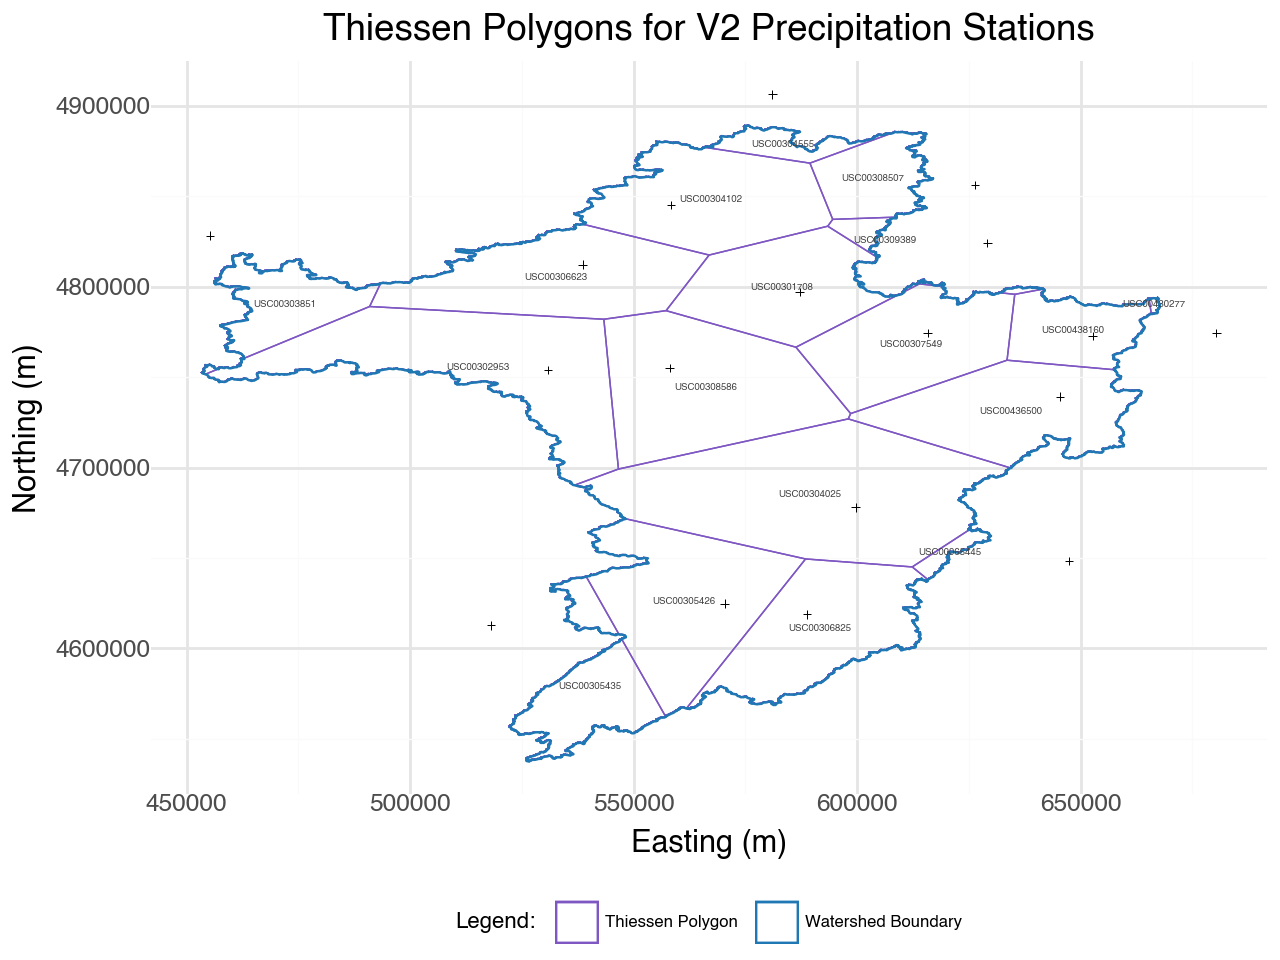

In [29]:
# Compute centroids for placing labels
thiessen_polygons_v2_ds['x'] = thiessen_polygons_v2_ds.centroid.x
thiessen_polygons_v2_ds['y'] = thiessen_polygons_v2_ds.centroid.y

# Add a new column to indicate the type of feature for color mapping
thiessen_polygons_v2_ds['feature_type'] = 'Thiessen Polygon'
upper_hudson_basin['feature_type'] = 'Watershed Boundary'

# Build the plot
thiessen_polygons_v2ds_map = (
    ggplot()
    
    # Thiessen Polygons layer
    + geom_map(
        data=thiessen_polygons_v2_ds,
        mapping=aes(geometry='geometry', color='feature_type'),
        fill=None,
        size=0.3,
        show_legend=True
    )
    
    # Precipitation Stations layer
    + geom_map(
        data=precip_stations_v2_filtered,
        mapping=aes(geometry='geometry'),
        shape = map_style.get('precipitation_station_v2').get('shape'),
        color = map_style.get('precipitation_station_v2').get('color'),
        fill = map_style.get('precipitation_station_v2').get('fill'),
        size =1.5, 
        stroke = 0.2
    )
    
    # Upper Hudson Basin layer
    + geom_map(
        data=upper_hudson_basin,
        mapping=aes(geometry='geometry', color='feature_type'),
        fill=None,
        show_legend=True
    )
    
    # Add labels for precipitation station IDs (using the centroids)
    + geom_text(
        data=thiessen_polygons_v2_ds,
        mapping=aes(x='x', y='y', label='StnID'),
        size=3.5,
        color=map_style.get('text').get('color')
    )
    
    # Set titles and axes labels
    + labs(title='Thiessen Polygons for V2 Precipitation Stations',
           x="Easting (m)", y="Northing (m)")
    
    + coord_cartesian()
    + theme_minimal()
    
    # Place the legend at the bottom and adjust text sizes
    + theme(
          legend_title=element_text(size=8),
          legend_text=element_text(size=6),
          legend_position='bottom'
      )
    
    # Manually assign colors to each mapped group
    + scale_color_manual(
          name="Legend:",
          values={
              'Thiessen Polygon': map_style.get('thiessen_polygon').get('color'),
              'Watershed Boundary': map_style.get('watershed_boundary').get('color')
          }
      )
)

# Display the plot
thiessen_polygons_v2ds_map.show()

In [292]:
parameters2 = {'stationid':'COOP:267369',
               'datasetid':'PRECIP_15',
               'startdate':'2012-10-31',
               'enddate':'2012-12-31'}
response2 = requests.get(url=base_url + 'data', headers=headers, params=parameters2)
response2.json()

NameError: name 'base_url' is not defined

In [296]:
save_workspace('data_preprocessing_workspace.pkl')

In [45]:
precip_stations_v2_clipped.to_file('precipitatio.GeoJSON', driver='GeoJSON')  
upper_hudson_basin.to_file('upper_hudson.GeoJSON', driver = 'GeoJSON')

AttributeError: 'Polygon' object has no attribute 'to_file'

In [46]:
upper_hudson_basin.crs

<Projected CRS: EPSG:26918>
Name: NAD83 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 78°W and 72°W - onshore and offshore. Canada - Nunavut; Ontario; Quebec. United States (USA) - Connecticut; Delaware; Maryland; Massachusetts; New Hampshire; New Jersey; New York; North Carolina; Pennsylvania; Virginia; Vermont.
- bounds: (-78.0, 28.28, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich